# Omitted Variable Bias And What Can We Do About It

In causal inference, **bias** is extremely problematic because it makes inference not valid. Bias generally means that an estimator will not deliver the estimate of the true effect, on average. 

This is why, in general, we prefer estimators that are **unbiased**, at the cost of a higher variance, i.e. more noise. Does it mean that every biased estimator is useless? Actually no. Sometimes, with domain knowledge, we can still draw causal conclusions even with a biased estimator.

In this post, we are going to review a specific but frequent source of bias, **omitted variable bias (OVB)**. We are going to explore the causes of the bias and leverage these insights to make causal statements, despite the bias.

## Theory

Suppose we are interested in the effect of a variable $D$ on a variable $y$. However, there is a third variable $Z$ that we do not observe and that is correlated with both $D$ and $Y$. Assume the data generating process can be represented with the following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c). If you are not familiar with DAGs, I have written a short [introduction here](https://towardsdatascience.com/b63dc69e3d8c).

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

D((D))
Z((Z))
Y((Y))

D --> Y
Z --> D
Z --> Y

class D,Y excluded;
class Z unobserved;
```
Since there is a [**backdoor path**](https://towardsdatascience.com/b63dc69e3d8c) from $D$ to $y$ passing through $Z$, we need to condition our analysis on $Z$ in order to recover the causal effect of $D$ on $y$. If we could observe $Z$, we would run a linear regression of $y$ on $D$ and $Z$ to estimate the following model:

$$
y = \alpha D + \gamma Z + \varepsilon
$$

where $\alpha$ is the effect of interest. This regression is usually referred to as the **long regression** since it includes all variables of the model. 

However, since we do not observe $Z$, so that we have to estimate the following model: 

$$
y = \alpha D + u
$$

The corresponding regression is usually referred to as the **short regression** since it does not include all the variables of the model

What is the **consequence** of estimating the short regression when the true model is the long one?

In that case, the OLS estimator of $\alpha$ is

$$
\begin{align}
\hat \alpha &= \frac{Cov(D, y)}{Var(D)} = 
\newline
&= \frac{Cov(D, \alpha D + \gamma Z + \varepsilon)}{Var(D)} =
\newline
&= \frac{Cov(D, \alpha D)}{Var(D)} + \frac{Cov(D, \gamma Z)}{Var(D)} + \frac{Cov(D, \varepsilon)}{Var(D)} =
\newline
&= \alpha + \underbrace{ \gamma \frac{Cov(D, Z)}{Var(D)} }_{\text{omitted variable bias}}
\end{align}
$$

Therefore, we can write the **omitted variable bias** as

$$
\text{OVB} = \gamma \delta \qquad \text{ where } \qquad \delta := \frac{Cov(D, Z)}{Var(D)}
$$

The beauty of this formula is its **interpretability**: the omitted variable bias consists in just **two components**, both extremely easy to interpret.

- $\gamma$: the effect of $Z$ on $y$
- $\delta$: the effect of $D$ on $Z$

### Additional Controls

What happens if we had **additional control variables** in the regression? For example, assume that besides the variable of interest $D$, we also observe a vector of other variables $X$ so that the **long regression** is 

$$
y = \alpha D + \beta X + \gamma Z + \varepsilon
$$

Thanks to the [**Frisch-Waugh-Lowell theorem**](https://towardsdatascience.com/59f801eb3299), we can simply **partial-out** $X$ and express the omitted variable bias in terms of $D$ and $Z$.

$$
\text{OVB} = \gamma \times \frac{Cov(D^{\perp X}, Z^{\perp X})}{Var(D^{\perp X})}
$$

where $D^{\perp X}$ are the residuals from regressing $D$ on $X$ and $Z^{\perp X}$ are the residuals from regressing $Z$ on $X$. If you are not familiar with Frisch-Waugh-Lowell theorem, I have written a short [note here](https://towardsdatascience.com/59f801eb3299).

[Chernozhukov, Cinelli, Newey, Sharma, Syrgkanis (2022)](https://arxiv.org/abs/2112.13398) further generalize to analysis the the setting in which the control variables $X$ and the unobserved variables $Z$ enter the long model with a general functional form $f$

$$
y = \alpha D + f(Z, X) + \varepsilon
$$

You can find more details in their paper, but the underlying idea remains the same.

## Example

Suppose we were a researcher interested in the relationship between **education** and **wages**. Does investing in education pay off in terms of future wages? Suppose we had data on wages for people with different years of education. Why not looking at the correlation between years of education and wages?

The problem is that there might be many **unobserved variables** that are correlated with both education and wages. For simplicity, let's concentrate on **ability**. People of higher ability might decide to invest more in education just because they are better in school and they get more opportunities. On the other hand, they might also get higher wages afterwards, purely because of their innate ability.

We can represent the data generating process with the following **Directed Acyclic Graph** (DAG).

```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

D((education))
Z((ability))
Y((wage))
X1((age))
X2((gender))

D --> Y
Z --> D
Z --> Y
X1 --> Y
X2 --> Y

class D,Y included;
class X1,X2 excluded;
class Z unobserved;
```

Let's load and inspect the **data**. I import the data generating process from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_educ_wages

df = dgp_educ_wages().generate_data(N=50)
df.head()

,age,gender,education,wage
0,62,male,6.0,3800.0
1,44,male,8.0,4500.0
2,63,male,8.0,4700.0
3,33,male,7.0,3500.0
4,57,female,6.0,4000.0


We have information on **300 individuals**, for which we observe their `age`, their `gender`, the years of `education`, and the current monthly `wage`.

Suppose we were directly regressing `wage` on `education`.  

In [3]:
model = smf.ols('wage ~ education + gender + age', df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2657.8864,444.996,5.973,0.000,1762.155,3553.618
gender[T.male],335.1075,132.685,2.526,0.015,68.027,602.188
education,95.9437,38.752,2.476,0.017,17.940,173.948
age,12.3120,6.110,2.015,0.050,0.013,24.611


The coefficient of `education` is positive and significant. However, we know there might be an **omitted variable bias**, because we do not observe `ability`. In terms of DAGs, there is a **backdoor path** from `education` to `wage` passing through `ability` that is not blocked and therefore biases our estimate.

```mermaid
flowchart TD
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

D((education))
Z((ability))
Y((wage))
X1((age))
X2((gender))

D --> Y
Z --> D
Z --> Y
X1 --> Y
X2 --> Y

class D,Y included;
class X1,X2 excluded;
class Z unobserved;

linkStyle 1,2 stroke:#ff0000,stroke-width:4px;
```

Does it mean that all our analysis is **garbage**? Can we still draw some causal conclusion from the regression results?

## Direction of the Bias

If we knew the signs of $\gamma$ and $\delta$, we could infer the sign of the bias, since it's the product of the two signs.

$$
\text{OVB} = \gamma \delta \qquad \text{ where } \qquad \gamma := \frac{Cov(Z, y)}{Var(Z)}, \quad \delta := \frac{Cov(D, Z)}{Var(D)}
$$

which in our example is

$$
\text{OVB} = \gamma \delta \qquad \text{ where } \qquad \gamma := \frac{Cov(\text{ability}, \text{wage})}{Var(\text{ability})}, \quad \delta := \frac{Cov(\text{education}, \text{ability})}{Var(\text{education})}
$$

Let's analyze the two correlations separately:

- The correlation between `ability` and `wage` is most likely positive
- The correlation between `ability` and `education` is most likely positive

Therefore, the bias is most likely **positive**. From this, we can conclude that our estimate from the regression on `wage` on `education` is most likely a **overestimate** of the true effect, which is most likely smaller.

This might seem like a small insight, but it's actually huge. Now we can say with confidence that one year of `education` increases `wages` by **at most** 95 dollars per month, which is a much more informative statement than just saying that the estimate is biased. 

## Further Sensitivity Analysis

Can we say **more** about the omitted variable bias without making strong assumptions?

The answer is yes! In particular, we can ask ourselves: how strong should the partial correlations $\gamma$ and $\delta$ be in order to **overturn** our conclusion?

In our example, we found a positive correlation between `education` and `wages` in the data. However, we know that we are omitting `ability` in the regression. The question is: how strong should the correlation between `ability` and `wage`, $\gamma$, and between `ability` and `education`, $\delta$, be in order to make the effect not significant or even negative?

[Cinelli and Hazlett (2020)](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssb.12348) show that we can transform this question in terms of residual variation explained, i.e. the [coefficient of determination, $R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination). The advantage of this approach is **interpretability**. It is much easier to make a guess about the percentage of variance explained than to make a guess about the magnitude of a conditional correlation. 

The authors wrote a companion package [`sensemakr`](https://github.com/carloscinelli/sensemakr) to conduct the sensitivity analysis. You can find a detailed description of the package [here](https://cran.r-project.org/web/packages/sensemakr/vignettes/sensemakr.html).

We will now use the `Sensemakr` function. The main **arguments** of the `Sensemakr` function are:

- `model`: the regression model we want to analyze
- `treatment`: the feature/covariate of interest, in our case `education`

The question we will try to answer is the following:

> *How much of the residual variation in `education` (x axis) and `wage` (y axis) does `ability` need to explain in order for the effect of `education` on `wages` to **change sign**?*

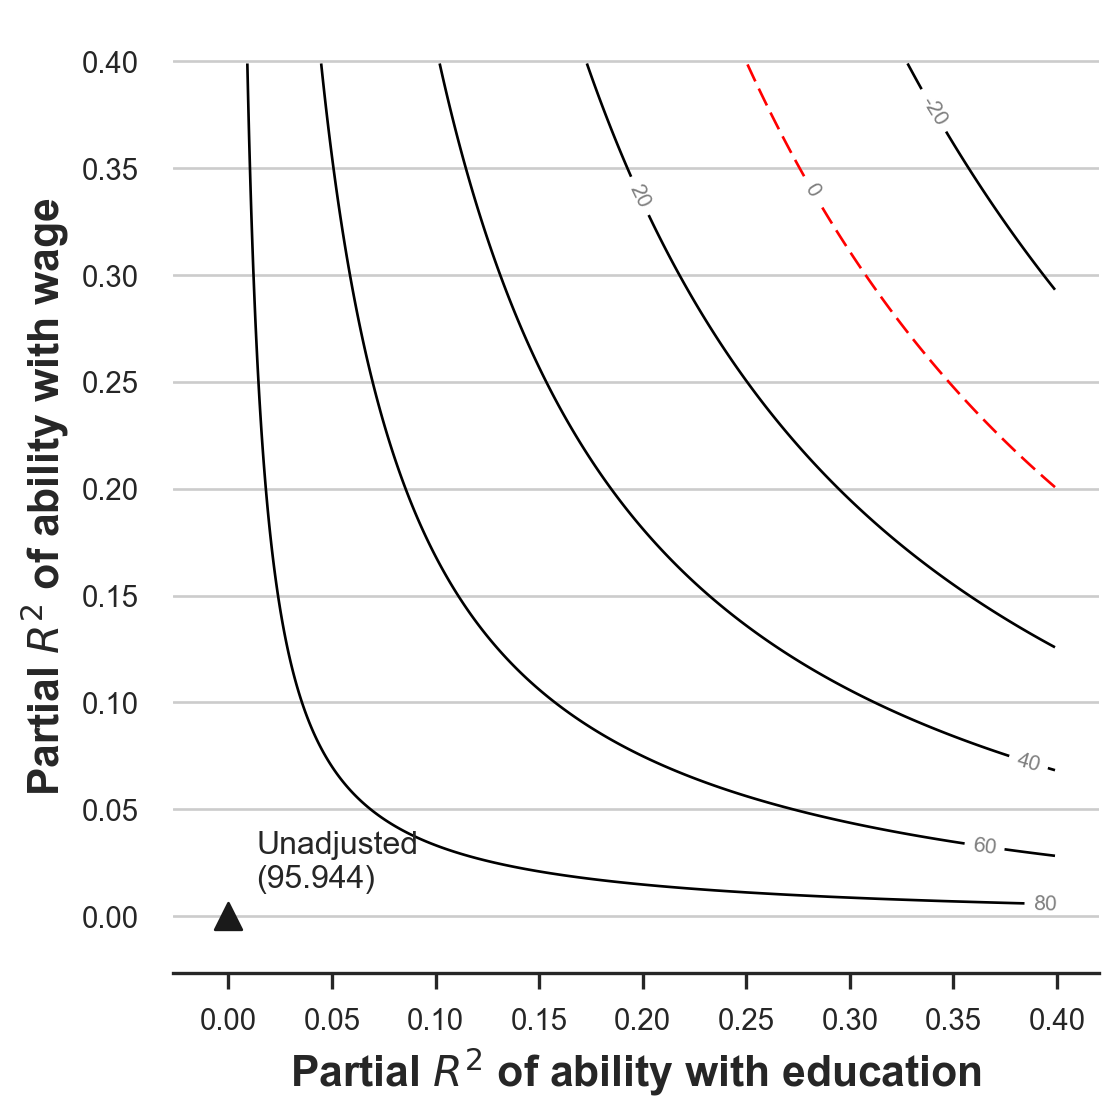

In [4]:
import sensemakr

sensitivity = sensemakr.Sensemakr(model = model, treatment = "education")
sensitivity.plot()
plt.xlabel("Partial $R^2$ of ability with education");
plt.ylabel("Partial $R^2$ of ability with wage");

In the **plot**, we see how the partial (because conditional on `age` and `gender`) $R^2$ of `ability` with `education` and `wage` affects the estimated coefficient of `education` on `wage`. The $(0,0)$ coordinate, marked with a **triangle**, corresponds to the current estimate and reflects what would happen if `ability` had no explanatory power for both `wage` with `education`: nothing. As the explanatory power of `ability` grows (moving upwards and rightwards from the triangle), the estimated coefficient decreases, as marked by the **level curves**, until it becomes zero at the **dotted red line**. 

How should we **interpret** the plot? We can see that we need `ability` to explain around 30% of the residual variation in both `education` and `wage` in order for the effect of `education` on `wages` to disappear, corresponding to the red line.

One question that you might (legitimately) have now is: what is 30%? Is it big or is it small? We can get a sense of the **magnitude** of the partial $R^2$ by **benchmarking** the results with the residual variance explained by another *observed* variable. Let's use `age` for example.

The `Sensemakr` function accepts the following optional arguments:

- `benchmark_covariates`: the covariate to use as a benchmark
- `kd` and `ky`: these arguments parameterize how many times stronger the unobserved variable (`ability`) is related to the treatment (`kd`) and to the outcome (`ky`) in comparison to the observed benchmark covariate (`age`). In our example, setting `kd` and `ky` equal to $[0.5, 1, 2]$ means we want to investigate the maximum strength of a variable half, same, or twice as strong as `age` (in explaining `education` and `wage` variation). 

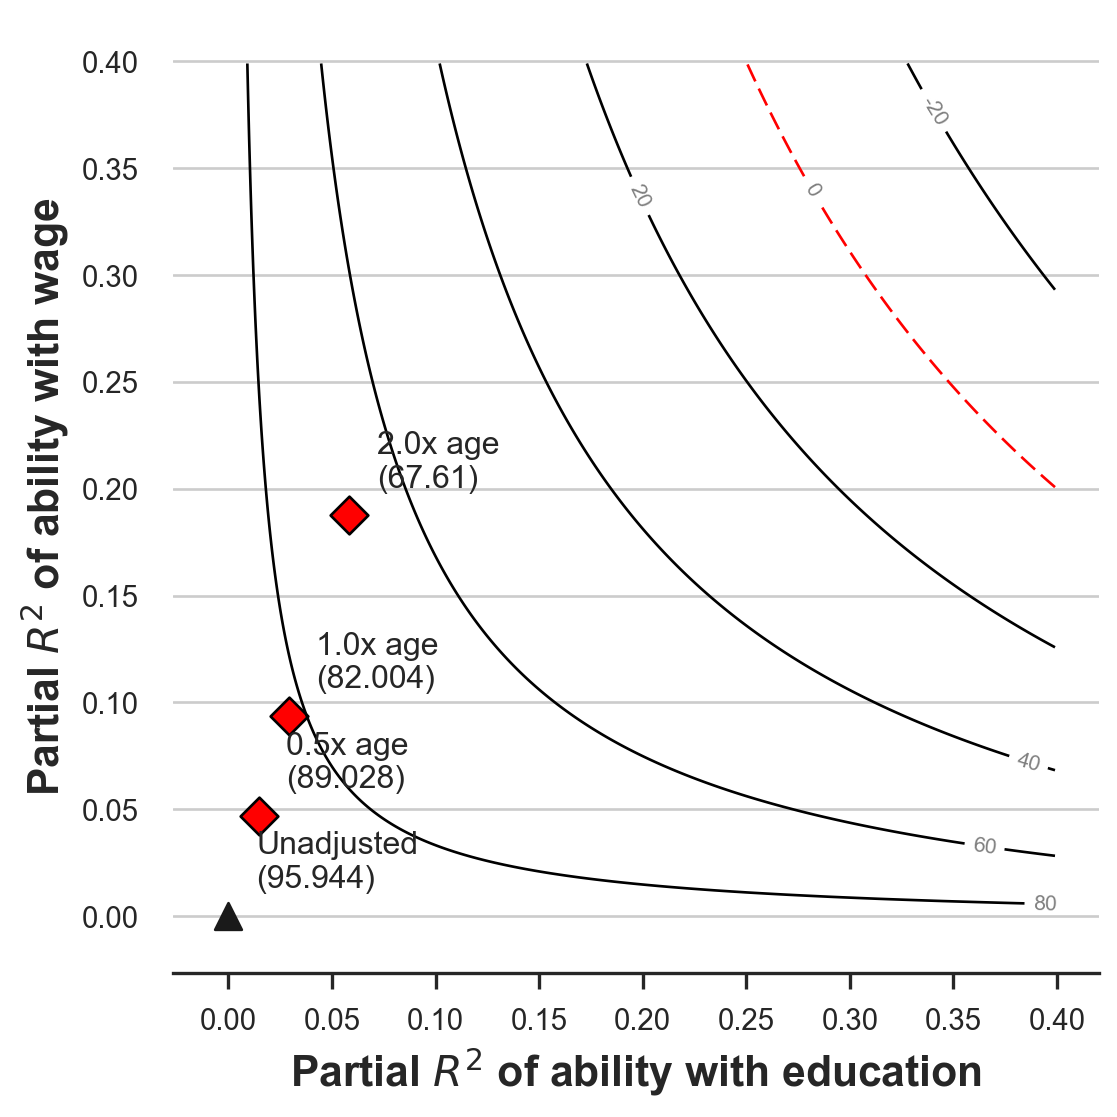

In [5]:
sensitivity = sensemakr.Sensemakr(model = model, 
                                  treatment = "education",
                                  benchmark_covariates = "age",
                                  kd = [0.5, 1, 2],
                                  ky = [0.5, 1, 2])
sensitivity.plot()
plt.xlabel("Partial $R^2$ of ability with education");
plt.ylabel("Partial $R^2$ of ability with wage");

It looks like even if `ability` had twice as much explanatory power as `age`, the effect of `education` on `wage` would still be positive. But would it be **statistically significant**?

We can repeat the same exercise, looking at the t-statistic instead of the magnitude of the coefficient. We just need to set the `sensitivity_of` option in the plotting function equal to `t-value`.

The question that we are trying to answer in this case is:

> *How much of the residual variation in `education` (x axis) and `wage` (y axis) does `ability` need to explain in order for the effect of `education` on `wages` to **become not significant**?*

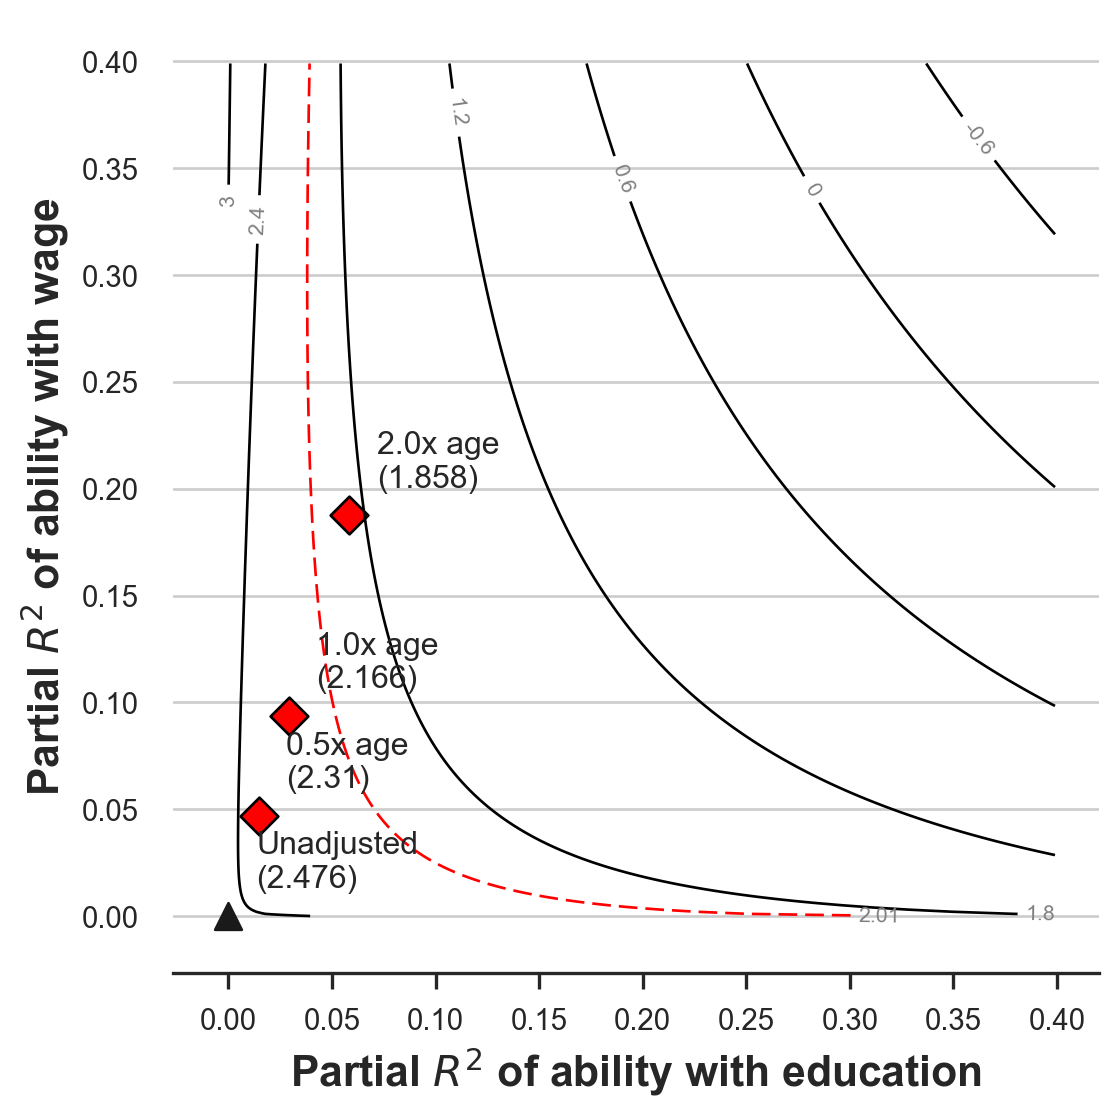

In [6]:
sensitivity.plot(sensitivity_of = 't-value')
plt.xlabel("Partial $R^2$ of ability with education");
plt.ylabel("Partial $R^2$ of ability with wage");

From the plot, we can see, we need `ability` to explain around 5% to 10% of the residual variation in both `education` and `wage` in order for the effect of `education` on `wage` not to be significant. In particular, the red line plots the level curve for the t-statistic equal to 2.01, corresponding to a 5% significance level. From the comparison with `age`, we see that a similar explanatory power (`1.0x age`) would be sufficient to make the coefficient of `education` on `wage` not statistically significant.

## Conclusion

In this post, I have introduced the concept of **omitted variable bias**. We have seen how it's computed in a simple linear model and how we can exploit qualitative information about the variables to make inference in presence of omitted variable bias.

These tools are extremely useful since omitted variable bias is essentially **everywhere**. First of all, there are always factors that we do not observe, such as ability in our toy example. However, even if we could observe everything, omitted variable bias can also emerge in the form of **model misspecification**. Suppose that `wages` depended on `age` in a quadratic way. Then, omitting the quadratic term from the regression introduces bias, which can be analyzed with the same tools we have used for `ability`.

### References

[1] C. Cinelli, C. Hazlett, [Making Sense of Sensitivity: Extending Omitted Variable Bias](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/rssb.12348) (2019), *Journal of the Royal Statistical Society*.

[2] V. Chernozhukov, C. Cinelli, W. Newey, A. Sharma, V. Syrgkanis, [Long Story Short: Omitted Variable Bias in Causal Machine Learning](https://arxiv.org/abs/2112.13398) (2022), working paper.

### Related Articles

- [The FWL Theorem, Or How To Make Regressions Intuitive](https://towardsdatascience.com/59f801eb3299)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code